In [ ]:
import os, cv2, random, json
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from predict_pipeline import CLASS_NAMES, get_pipeline_predictions

In [36]:
test_image_root = "../data/raw/test/disease/input"
test_label_path = "../data/raw/test/disease/label"
IoU_treshold = 0.4

In [37]:
def pick_random_test_image(image_root):
    images = [f for f in os.listdir(image_root)
              if f.lower().endswith(".png")]

    if len(images) == 0:
        raise ValueError("Test klasöründe image bulunamadı")

    return random.choice(images)


In [38]:
def parse_stage2_test_json(json_path, target_image_name):
    ground_truths = []

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    json_image_name = data.get("imagePath")

    if json_image_name != target_image_name:
        raise ValueError(
            f"JSON imagePath ({json_image_name}) "
            f"ile seçilen image ({target_image_name}) eşleşmiyor"
        )

    for shape in data["shapes"]:
        label = shape["label"].lower()

        # --- SINIF EŞLEME ---
        if "çürük" in label:
            cls_id = 5  # Caries
        elif "gömülü" in label:
            cls_id = 4  # Impacted
        else:
            continue  # stage-2 için alakasız

        points = shape["points"]
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]

        x1, y1 = int(min(xs)), int(min(ys))
        x2, y2 = int(max(xs)), int(max(ys))

        ground_truths.append({
            "cls": cls_id,
            "bbox": [x1, y1, x2, y2]
        })

    return ground_truths


In [39]:
def calculate_iou(boxA, boxB):
    #İki kutu arasındaki Intersection over Union (IoU) oranını hesaplar.
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)


def draw_boxes(img, boxes, color, title):
    canvas = img.copy()
    cv2.putText(canvas, title, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)

    for item in boxes:
        x1, y1, x2, y2 = item['bbox']
        cls_name = CLASS_NAMES.get(item['cls'], str(item['cls']))
        cv2.rectangle(canvas, (x1, y1), (x2, y2), color, 2)
        cv2.putText(canvas, cls_name, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return canvas



📊 BAŞARI RAPORU: test_161.png
✅ Eşleşen: 1
❌ Kaçırılan: 7
⚠️ Ghost: 6
📈 GT: 8 | 🤖 Pred: 7


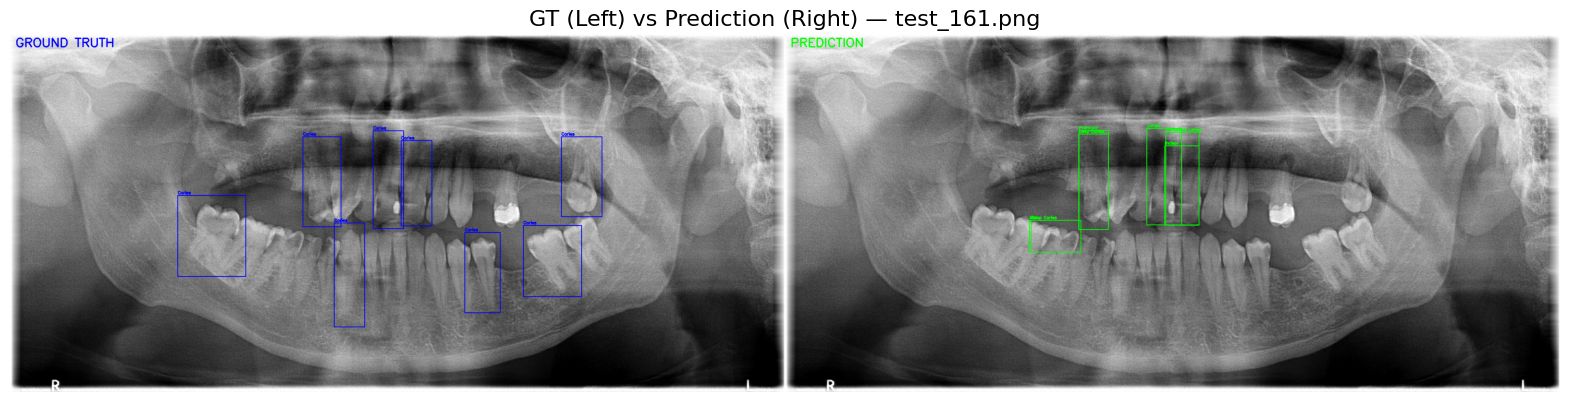

In [40]:
def main():
    # 1️⃣ random test image seç
    image_files = [
        f for f in os.listdir(test_image_root)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    if len(image_files) == 0:
        raise ValueError("Test image klasöründe görüntü yok")

    image_name = random.choice(image_files)
    image_path = os.path.join(test_image_root, image_name)

    # 2️⃣ image'e karşılık gelen label json
    label_name = image_name.replace(".png", ".json")
    label_path = os.path.join(test_label_path, label_name)

    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Label bulunamadı: {label_path}")

    # 3️⃣ prediction
    preds, original_img = get_pipeline_predictions(image_path)

    # 4️⃣ GT
    gts = parse_stage2_test_json(label_path, image_name)

    # 5️⃣ matching
    matches = ghosts = 0
    matched_gt_indices = set()

    for p in preds:
        best_iou = 0
        best_gt_idx = -1

        for i, g in enumerate(gts):
            if i in matched_gt_indices:
                continue
            if p["cls"] != g["cls"]:
                continue

            iou = calculate_iou(p["bbox"], g["bbox"])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i

        if best_iou >= IoU_treshold:
            matches += 1
            matched_gt_indices.add(best_gt_idx)
        else:
            ghosts += 1

    missed = len(gts) - len(matched_gt_indices)

    print("\n" + "=" * 40)
    print(f"📊 BAŞARI RAPORU: {image_name}")
    print("=" * 40)
    print(f"✅ Eşleşen: {matches}")
    print(f"❌ Kaçırılan: {missed}")
    print(f"⚠️ Ghost: {ghosts}")
    print(f"📈 GT: {len(gts)} | 🤖 Pred: {len(preds)}")
    print("=" * 40)

    # 6️⃣ Jupyter görselleştirme
    img_gt = draw_boxes(original_img, gts, (255, 0, 0), "GROUND TRUTH")
    img_pred = draw_boxes(original_img, preds, (0, 255, 0), "PREDICTION")

    comparison = np.hstack((img_gt, img_pred))

    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(comparison, cv2.COLOR_BGR2RGB))
    plt.title(f"GT (Left) vs Prediction (Right) — {image_name}", fontsize=16)
    plt.axis("off")
    plt.show()
main()